In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CMAPSS
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CMAPSS
/content/drive/MyDrive/CMAPSS


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# ========== Load Data ==========

def load_data(train_path, test_path, rul_path):
    column_names = ['unit_number', 'time_in_cycles',
                    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                    [f'sensor_measurement_{i}' for i in range(1, 22)]

    train_df = pd.read_csv(train_path, sep=' ', header=None)
    train_df.drop(columns=[26, 27], inplace=True)
    train_df.columns = column_names

    test_df = pd.read_csv(test_path, sep=' ', header=None)
    test_df.drop(columns=[26, 27], inplace=True)
    test_df.columns = column_names

    rul_df = pd.read_csv(rul_path, header=None)

    return train_df, test_df, rul_df

In [ ]:
# ========== Preprocess ==========

def compute_rul(train_df, test_df, rul_df):
    train_rul = train_df.groupby('unit_number')['time_in_cycles'].max()
    train_df['RUL'] = train_df.apply(lambda row: train_rul[row['unit_number']] - row['time_in_cycles'], axis=1)
    # Domain knowledge: RUL-clipping: any RUL > 165 treated as 165
    # NOTE:
    # I found that changing RUL range affects the final RMSE a lot since
    # engines that have had very few cycles are less likely to break down
    # and the noise for predicting highter RUL accurately increases

    train_df['RUL'] = train_df['RUL'].clip(upper=165)
    # For test set, get last cycle per unit
    test_rul = test_df.groupby('unit_number').last().reset_index()
    test_rul['RUL'] = rul_df.values

    return train_df, test_rul

In [ ]:
def add_rolling_features(df, sensor_cols, window=10):
    df_sorted = df.sort_values(by=['unit_number', 'time_in_cycles'])

    for col in sensor_cols:
        new_col = f'{col}_rollmean{window}'
        df_sorted[new_col] = (
            df_sorted
            .groupby('unit_number')[col]
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )

    return df_sorted

In [ ]:
def prepare_datasets(train_df, test_rul, sensor_cols=None):
    import numpy as np


    if sensor_cols is None:
      sensor_cols = [col for col in train_df.columns if 'sensor_measurement' in col]
    drop_cols = ['unit_number','time_in_cycles','operational_setting_1','operational_setting_2','operational_setting_3']

    # Split engine IDs
    engines = train_df['unit_number'].unique()
    train_ids, val_ids = train_test_split(engines, test_size=0.1, random_state=42)

    # --- Train set ---
    X_train = train_df[train_df['unit_number'].isin(train_ids)][sensor_cols]
    y_train = train_df[train_df['unit_number'].isin(train_ids)]['RUL']

    # --- Validation set (pick a random cycle per engine) ---
    val_samples = []
    for engine_id in val_ids:
        engine_data = train_df[train_df['unit_number'] == engine_id]
        random_row = engine_data.sample(n=1, random_state=42)  # Fix seed for reproducibility
        val_samples.append(random_row)

    val_df = pd.concat(val_samples)
    X_val = val_df[sensor_cols]
    y_val = val_df['RUL']

    # --- Test set ---
    X_test = test_rul[sensor_cols]
    y_test = test_rul['RUL']

    return X_train, y_train, X_val, y_val, X_test, y_test, sensor_cols


In [ ]:
def scale_data(X_train, X_val, X_test):
    scaler = MinMaxScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)
    return X_train_s, X_val_s, X_test_s, scaler

In [ ]:
# ========== Custom Linear Regression ==========

class Linear_Regression:
    def __init__(self, lr=0.001, iterations=5000):
        self.lr = lr
        self.iterations = iterations

    def fit(self, X, Y):
        self.l, self.p = X.shape
        self.W = np.zeros(self.p)
        self.b = 0
        self.X = X
        self.Y = Y
        for _ in range(self.iterations):
            self._update_weights()
        return self

    def _update_weights(self):
        Y_pred = self.predict(self.X)
        dW = -2 * self.X.T.dot(self.Y - Y_pred) / self.l
        db = -2 * np.sum(self.Y - Y_pred) / self.l
        self.W -= self.lr * dW
        self.b -= self.lr * db

    def predict(self, X):
        return X.dot(self.W) + self.b

In [ ]:
# ========== Evaluation ==========

def evaluate(y_true, y_pred, label=''):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"{label} → RMSE: {rmse:.3f}, MAE: {mae:.3f}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# (Other functions: load_data, compute_rul, prepare_datasets, scale_data, Linear_Regression, evaluate)

# ========== Exploratory Visualizations ==========
def exploratory_visualizations(train_df, sensor_cols, corr_threshold=0.8):
    # 1a) Engine lifetime distribution
    print("""

    Plotting engine lifetime distribution → shows how many cycles engines typically run before failure.

    """)
    lifetimes = train_df.groupby('unit_number')['time_in_cycles'].max()
    plt.figure(figsize=(6,4))
    sns.histplot(lifetimes, bins=30, kde=True)
    plt.title('Engine Lifetime Distribution'); plt.xlabel('Cycles'); plt.ylabel('Count')
    plt.grid(True); plt.show()

    # 1b) Sensor correlation heatmap
    print("""

    Plotting sensor correlation heatmap → identifies highly correlated sensors (for possible feature reduction).

    """)
    corr = train_df[sensor_cols].corr()
    # Print pairs above threshold
    high_corr = []
    for i in range(len(sensor_cols)):
        for j in range(i+1, len(sensor_cols)):
            if abs(corr.iloc[i,j]) >= corr_threshold:
                high_corr.append((sensor_cols[i], sensor_cols[j], corr.iloc[i,j]))
    if high_corr:
        print(f"Sensor pairs with |corr| ≥ {corr_threshold}: ")
        for s1, s2, val in high_corr:
            print(f"  {s1} ↔ {s2}: {val:.2f}")
    else:
        print(f"No sensor pairs exceed correlation threshold of {corr_threshold}.")

    plt.figure(figsize=(12,12))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
                xticklabels=sensor_cols, yticklabels=sensor_cols)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title('Sensor–Sensor Correlation Heatmap')
    plt.tight_layout(); plt.show()

    # 1c) Boxplots of sensor distributions (4 per figure)
    print("""

    Plotting boxplots of each sensor (fliers hidden) → sees overall ranges and potential skew/outliers.

    """)
    sensors_per_fig = 4
    for i in range(0, len(sensor_cols), sensors_per_fig):
        fig, axes = plt.subplots(2, 2, figsize=(8,6))
        axes = axes.flatten()
        for j in range(sensors_per_fig):
            idx = i + j
            if idx < len(sensor_cols):
                sensor = sensor_cols[idx]
                axes[j].boxplot(train_df[sensor], showfliers=False)
                axes[j].set_title(sensor)
                axes[j].grid(True)
            else:
                axes[j].axis('off')
        plt.tight_layout(); plt.show()

    # 1d) Sample sensor vs RUL curves (every 10th engine for all sensors)
    print("""

    Plotting rolling-mean sensor behavior vs RUL for select engines → inspects degradation trends.

    """)
    n_rows = int(np.ceil(len(sensor_cols) / 2))
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 3 * n_rows))
    axes = axes.flatten()
    for idx, sensor in enumerate(sensor_cols):
        for uid in train_df['unit_number'].unique():
            if uid % 10 == 0:
                sub = train_df[train_df['unit_number']==uid]
                axes[idx].plot(sub['RUL'], sub[sensor].rolling(10).mean(), alpha=0.6)
        axes[idx].set_xlim(250, 0)
        axes[idx].set_title(f'{sensor} vs RUL')
        axes[idx].set_xlabel('RUL')
        axes[idx].set_ylabel(sensor)
        axes[idx].grid(True)
    for j in range(len(sensor_cols), len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()


In [ ]:
# ========== Predicted vs True Scatter‐Plots ==========

def plot_predicted_vs_true(y_true, y_pred, title):
    print(f"""

    Scatter plot of predictions → how close points lie to the ideal y=x line.

    """)
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.5)            # :contentReference[oaicite:1]{index=1}
    m = max(max(y_true), max(y_pred))
    plt.plot([0,m],[0,m], linestyle='--')            # ideal line
    plt.xlabel('True RUL'); plt.ylabel('Predicted RUL')
    plt.title(title)
    plt.tight_layout(); plt.show()

In [ ]:
# ========== Main Pipeline ==========

def run_pipeline(train_path, test_path, rul_path, sensor_cols=None, rolling_window=False):
    # Load + Preprocess
    train_df, test_df, rul_df = load_data(train_path, test_path, rul_path)
    train_df, test_rul = compute_rul(train_df, test_df, rul_df)

    # Auto-select sensor columns if not provided
    if sensor_cols is None:
        sensor_cols = [c for c in train_df.columns if 'sensor' in c]

    # Add rolling mean features
    if rolling_window == True:
      window = 20
      rolling_sensor_cols = [f'{c}_rollmean{window}' for c in sensor_cols]
      train_df = add_rolling_features(train_df, sensor_cols, window)
      test_rul = add_rolling_features(test_rul, sensor_cols, window)

      # Update full sensor list
      sensor_cols += rolling_sensor_cols

    # Visualizations
    exploratory_visualizations(train_df, sensor_cols)

    X_train, y_train, X_val, y_val, X_test, y_test, sensor_cols = prepare_datasets(train_df, test_rul, sensor_cols)
    X_train_s, X_val_s, X_test_s, scaler = scale_data(X_train, X_val, X_test)

    # custom LR
    print("""

    \nTraining Custom Linear Regression...

    """)
    custom = Linear_Regression(lr=0.001, iterations=5000).fit(X_train_s, y_train.values)
    y_pred_train = custom.predict(X_train_s); evaluate(y_train, y_pred_train, 'Custom Train')
    y_pred_val   = custom.predict(X_val_s);   evaluate(y_val, y_pred_val, 'Custom Validation')
    y_pred_test  = custom.predict(X_test_s);  evaluate(y_test, y_pred_test, 'Custom Test')
    plot_predicted_vs_true(y_test, y_pred_test, 'Custom: True vs Predicted')

    # sklearn LR
    print("""

    \nTraining Sklearn Linear Regression...

    """)
    skl = SklearnLinearRegression().fit(X_train_s, y_train)
    y_pred_train2 = skl.predict(X_train_s); evaluate(y_train, y_pred_train2, 'Sklearn Train')
    y_pred_val2   = skl.predict(X_val_s);   evaluate(y_val, y_pred_val2, 'Sklearn Validation')
    y_pred_test2  = skl.predict(X_test_s);  evaluate(y_test, y_pred_test2, 'Sklearn Test')
    plot_predicted_vs_true(y_test, y_pred_test2, 'Sklearn: True vs Predicted')


    # ========== Additional Standard Models ==========
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    import xgboost as xgb

    models = {
        'SVR (rbf)': SVR(C=0.1, epsilon=0.05, kernel='rbf'),
        'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, max_depth=10),
        'XGBoost': xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, max_depth=5)
    }

    for name, model in models.items():
        print(f"\nTraining {name}...")
        # fit on the same scaled training data
        model.fit(X_train_s, y_train)

        # evaluate on train / val / test
        y_tr = model.predict(X_train_s); evaluate(y_train, y_tr, f'{name} Train')
        y_va = model.predict(X_val_s);   evaluate(y_val,   y_va,   f'{name} Validation')
        y_te = model.predict(X_test_s);  evaluate(y_test,  y_te,  f'{name} Test')
        # optional scatter
        plot_predicted_vs_true(y_test, y_te, f'{name}: True vs Predicted')


In [ ]:
# ========== Run Pipeline with all sensors and no rolling window ==========

# run_pipeline(
#     train_path='CMAPSSData/train_FD001.txt',
#     test_path='CMAPSSData/test_FD001.txt',
#     rul_path='CMAPSSData/RUL_FD001.txt'
# )

In [ ]:
# ========== Run Pipeline with only useful sensors and no rolling window ==========

reduced_sensor_cols = ['sensor_measurement_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]

# run_pipeline(train_path='CMAPSSData/train_FD001.txt',
#     test_path='CMAPSSData/test_FD001.txt',
#     rul_path='CMAPSSData/RUL_FD001.txt',
#     sensor_cols=reduced_sensor_cols)



    Plotting engine lifetime distribution → shows how many cycles engines typically run before failure.

    


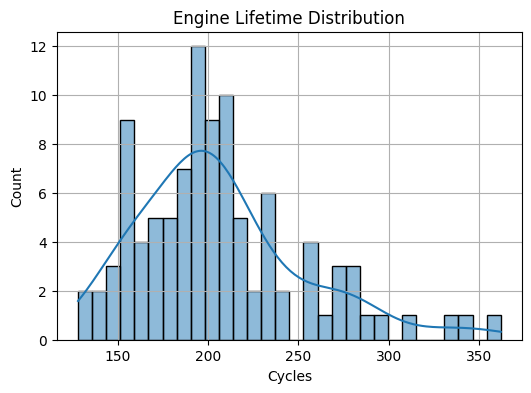



    Plotting sensor correlation heatmap → identifies highly correlated sensors (for possible feature reduction).

    
Sensor pairs with |corr| ≥ 0.8: 
  sensor_measurement_2 ↔ sensor_measurement_2_rollmean20: 0.81
  sensor_measurement_4 ↔ sensor_measurement_11: 0.83
  sensor_measurement_4 ↔ sensor_measurement_12: -0.82
  sensor_measurement_4 ↔ sensor_measurement_2_rollmean20: 0.87
  sensor_measurement_4 ↔ sensor_measurement_3_rollmean20: 0.87
  sensor_measurement_4 ↔ sensor_measurement_4_rollmean20: 0.90
  sensor_measurement_4 ↔ sensor_measurement_7_rollmean20: -0.87
  sensor_measurement_4 ↔ sensor_measurement_11_rollmean20: 0.88
  sensor_measurement_4 ↔ sensor_measurement_12_rollmean20: -0.88
  sensor_measurement_4 ↔ sensor_measurement_15_rollmean20: 0.88
  sensor_measurement_4 ↔ sensor_measurement_17_rollmean20: 0.87
  sensor_measurement_4 ↔ sensor_measurement_20_rollmean20: -0.88
  sensor_measurement_4 ↔ sensor_measurement_21_rollmean20: -0.88
  sensor_measurement_7 ↔ sensor_meas

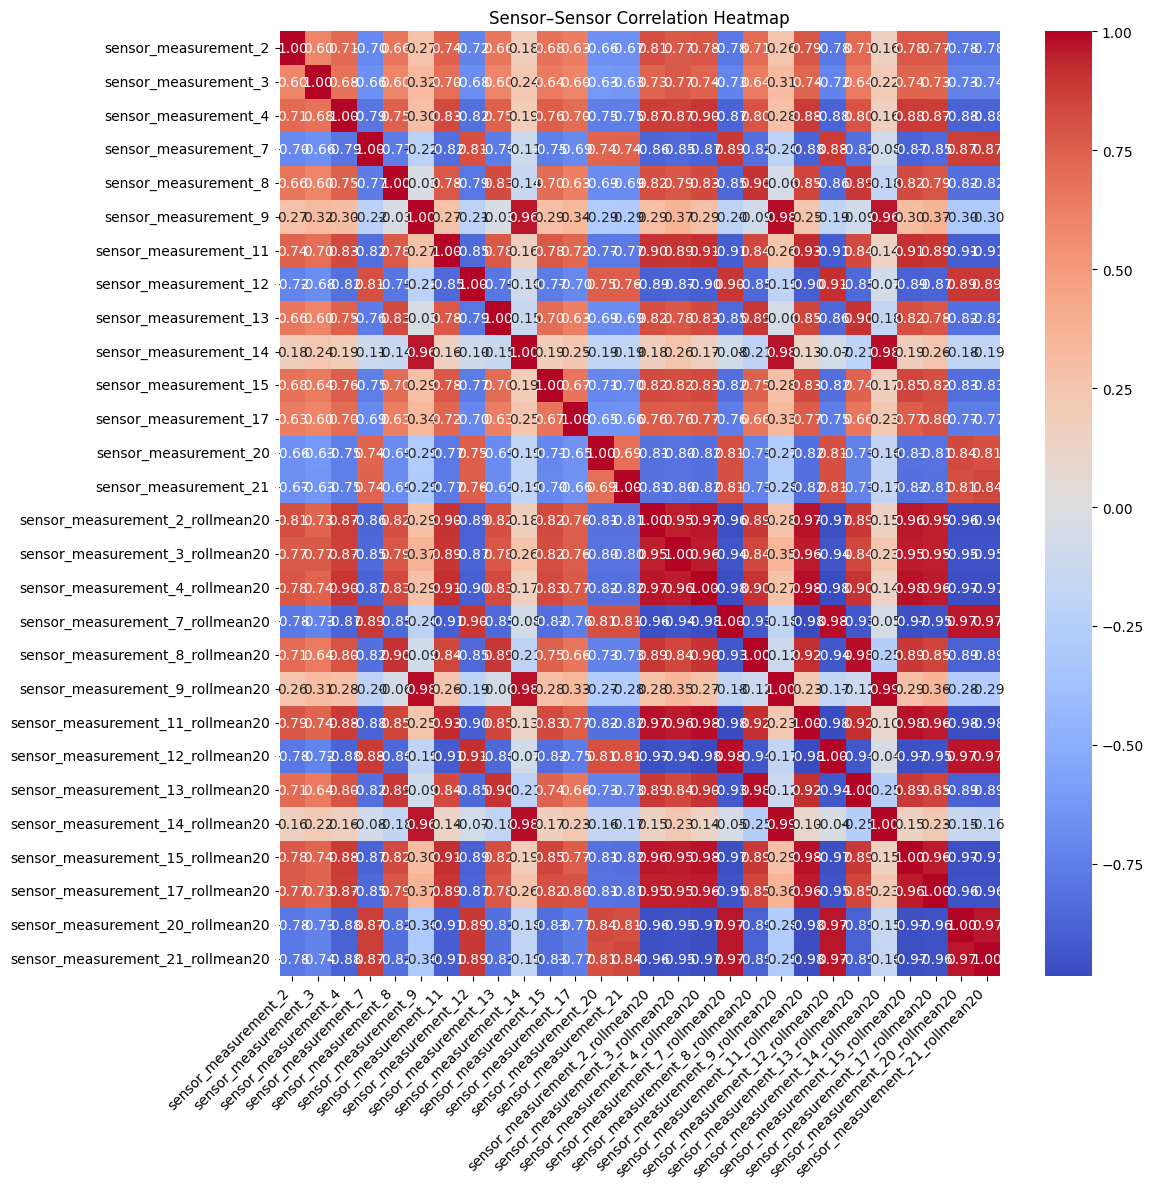



    Plotting boxplots of each sensor (fliers hidden) → sees overall ranges and potential skew/outliers.

    


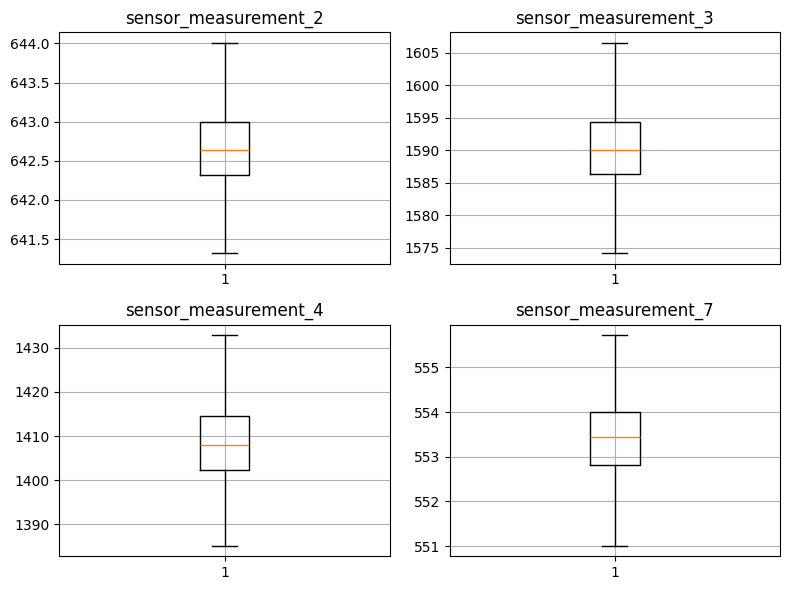

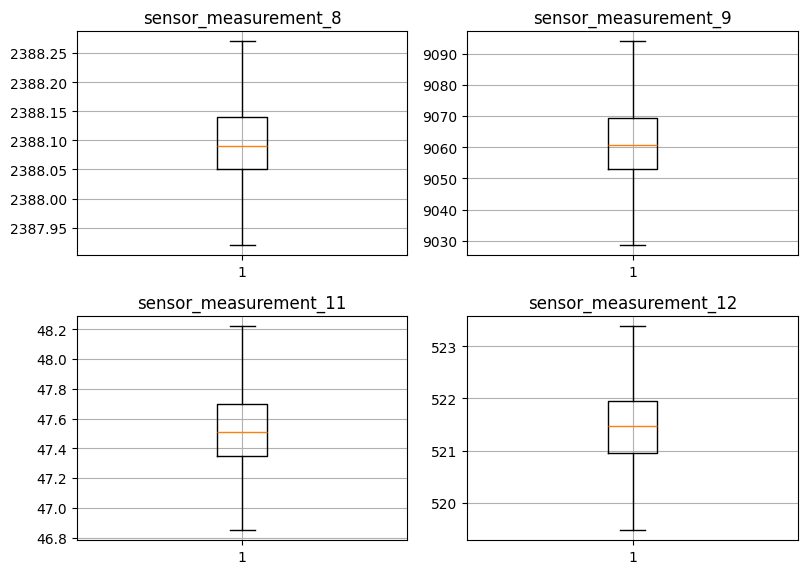

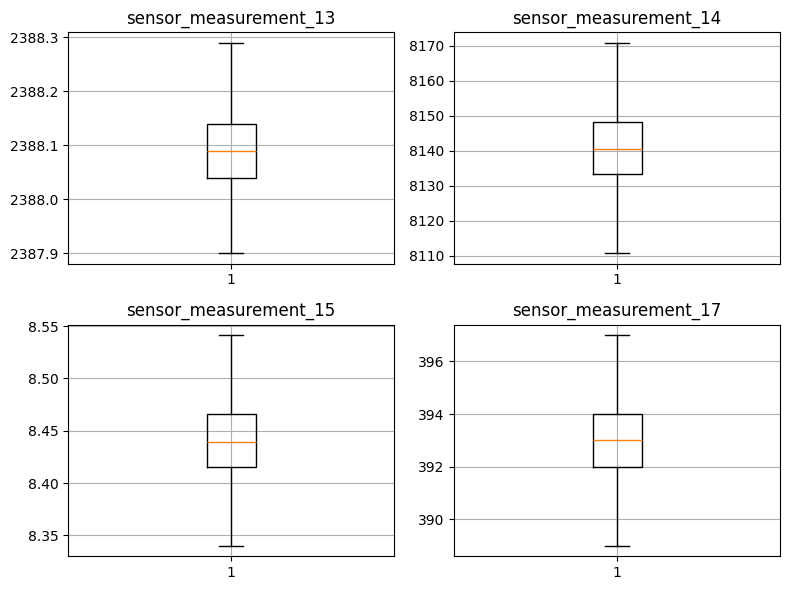

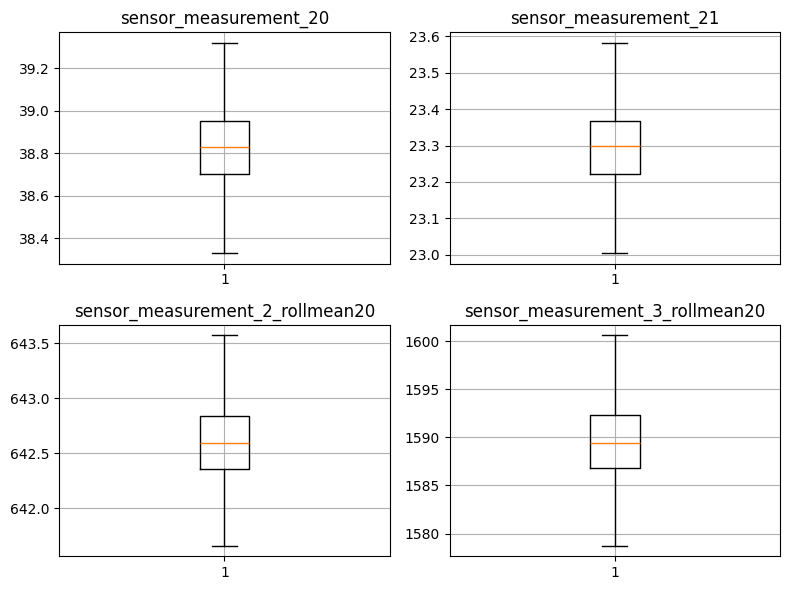

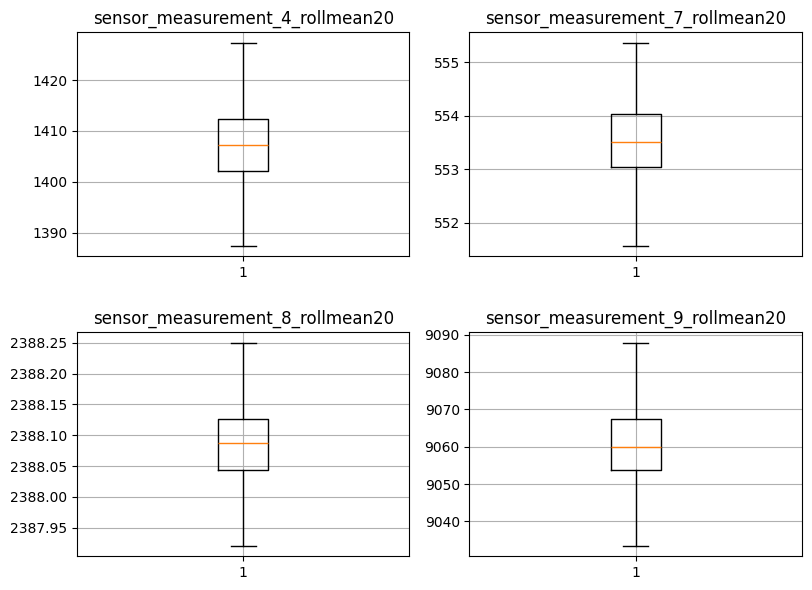

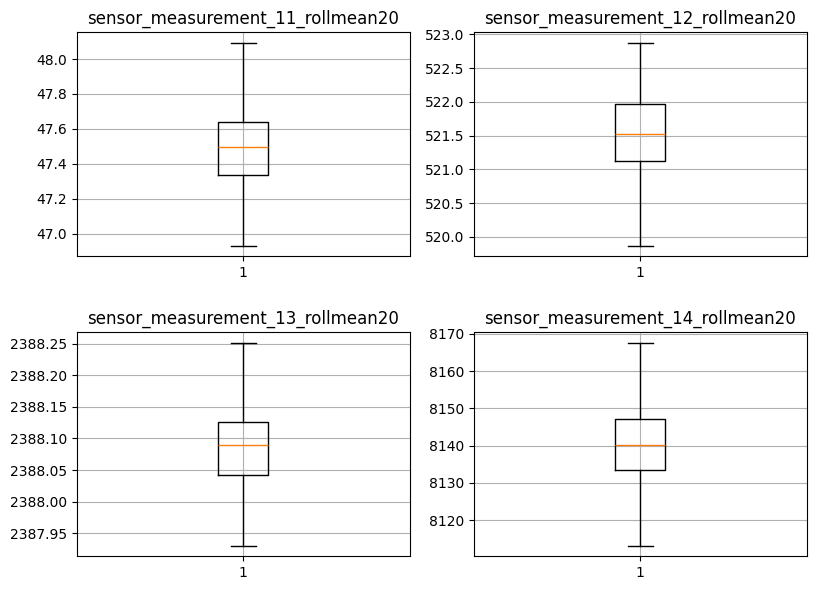

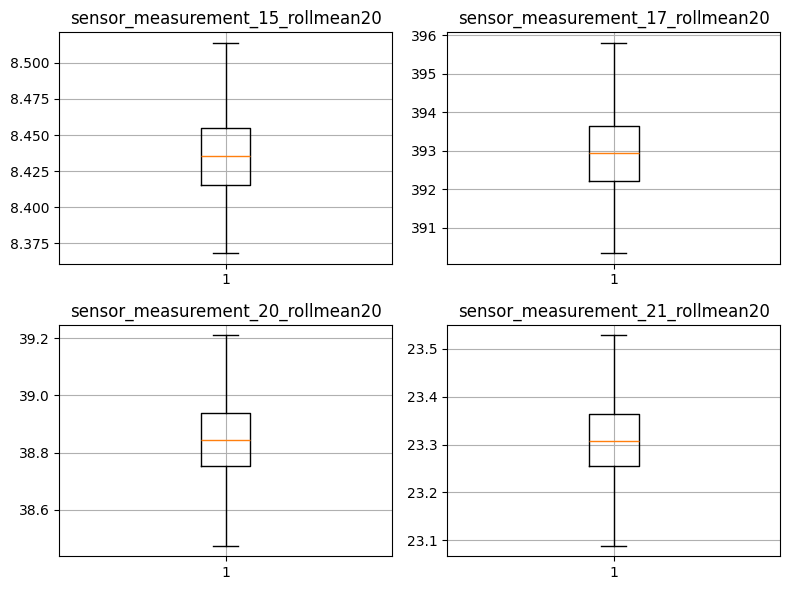



    Plotting rolling-mean sensor behavior vs RUL for select engines → inspects degradation trends.

    


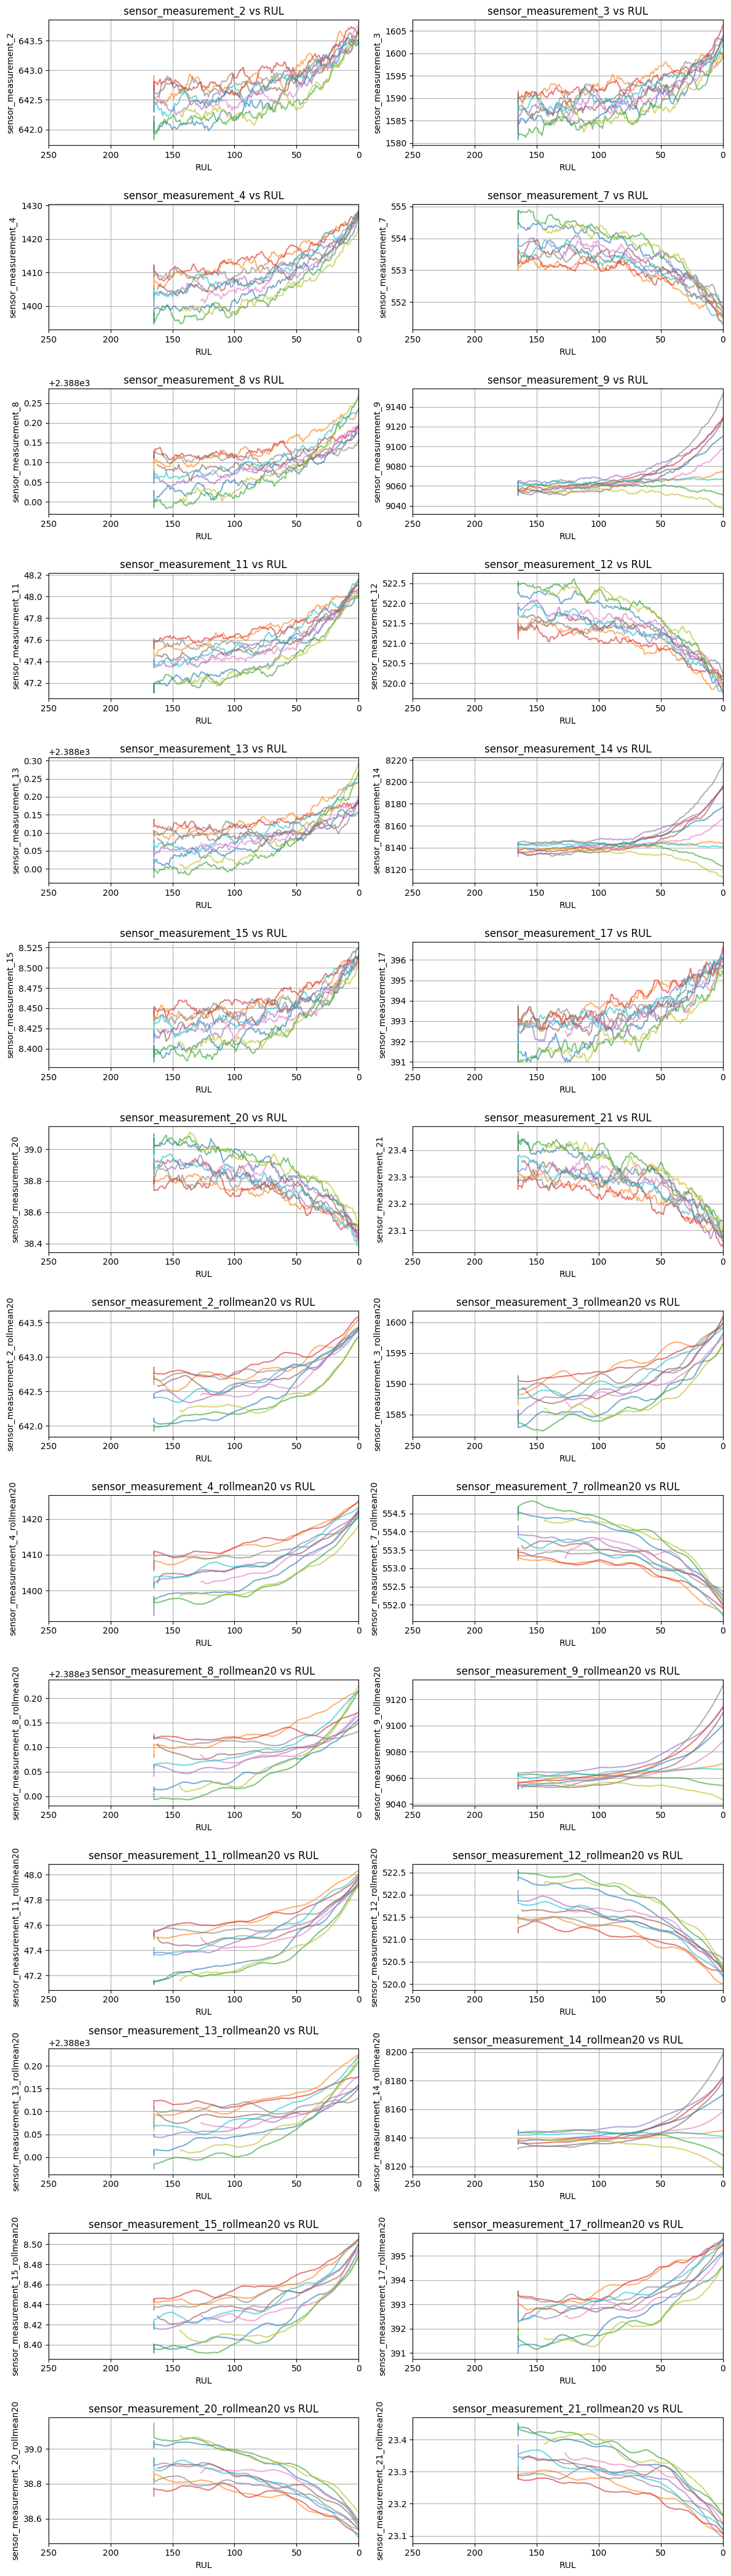



    
Training Custom Linear Regression...

    
Custom Train → RMSE: 32.234, MAE: 25.928
Custom Validation → RMSE: 36.408, MAE: 29.898
Custom Test → RMSE: 25.427, MAE: 19.981


    Scatter plot of predictions → how close points lie to the ideal y=x line.

    


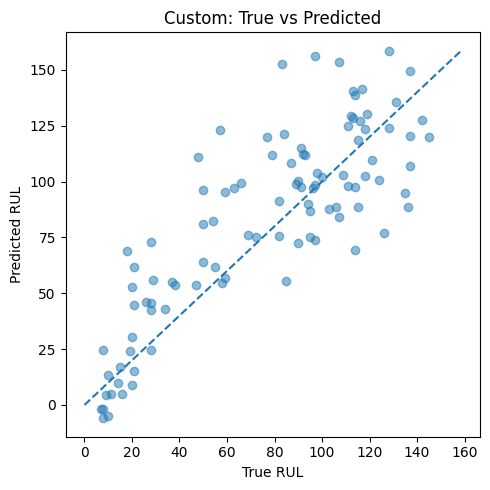



    
Training Sklearn Linear Regression...

    
Sklearn Train → RMSE: 29.822, MAE: 24.487
Sklearn Validation → RMSE: 32.700, MAE: 28.457
Sklearn Test → RMSE: 30.998, MAE: 24.380


    Scatter plot of predictions → how close points lie to the ideal y=x line.

    


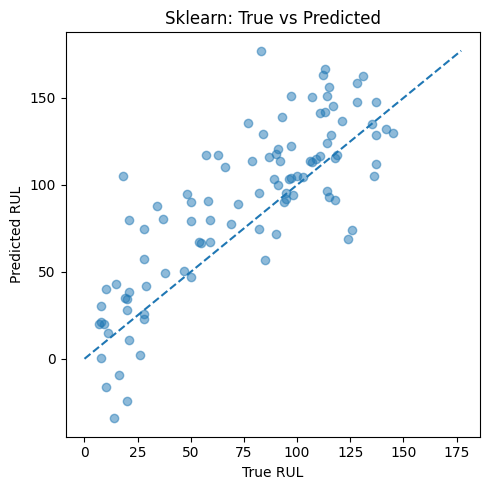


Training SVR (rbf)...
SVR (rbf) Train → RMSE: 29.088, MAE: 23.408
SVR (rbf) Validation → RMSE: 30.249, MAE: 23.615
SVR (rbf) Test → RMSE: 20.826, MAE: 15.435


    Scatter plot of predictions → how close points lie to the ideal y=x line.

    


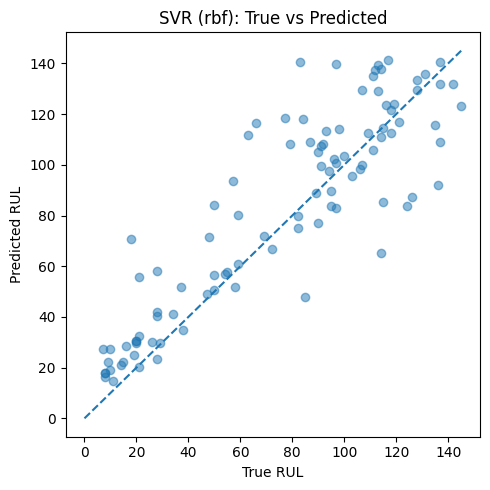


Training RandomForest...
RandomForest Train → RMSE: 18.416, MAE: 12.850
RandomForest Validation → RMSE: 19.149, MAE: 13.891
RandomForest Test → RMSE: 23.802, MAE: 17.285


    Scatter plot of predictions → how close points lie to the ideal y=x line.

    


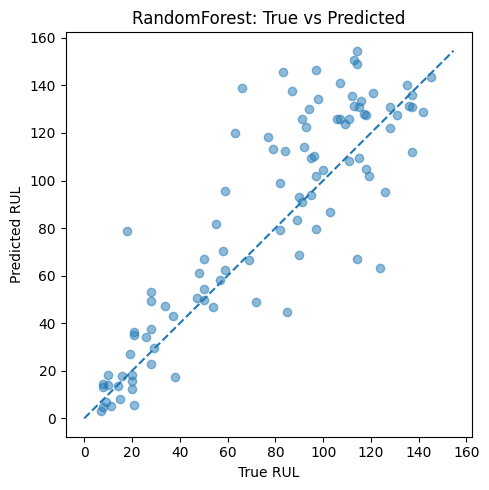


Training XGBoost...
XGBoost Train → RMSE: 17.169, MAE: 12.812
XGBoost Validation → RMSE: 22.481, MAE: 17.680
XGBoost Test → RMSE: 35.357, MAE: 26.759


    Scatter plot of predictions → how close points lie to the ideal y=x line.

    


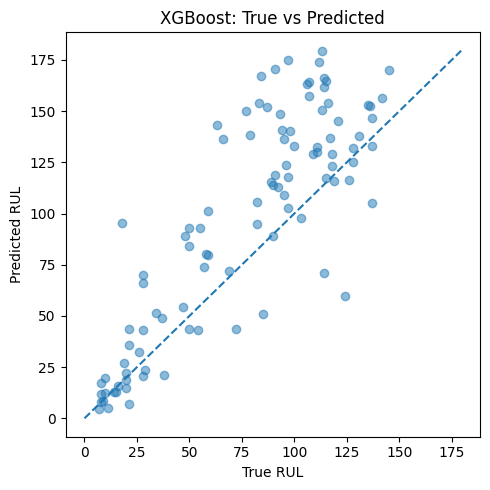

In [ ]:
# ========== Run Pipeline with only useful sensors and WITH rolling window ==========

reduced_sensor_cols = ['sensor_measurement_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]

run_pipeline(train_path='CMAPSSData/train_FD001.txt',
    test_path='CMAPSSData/test_FD001.txt',
    rul_path='CMAPSSData/RUL_FD001.txt',
    sensor_cols=reduced_sensor_cols, rolling_window=True)

Validation  RUL summary:
count     10.000000
mean      86.800000
std       67.108204
min        4.000000
25%       29.250000
50%       68.500000
75%      160.250000
max      165.000000
Name: RUL, dtype: float64

Test  RUL summary:
count    100.00000
mean      75.52000
std       41.76497
min        7.00000
25%       32.75000
50%       86.00000
75%      112.25000
max      145.00000
Name: RUL, dtype: float64


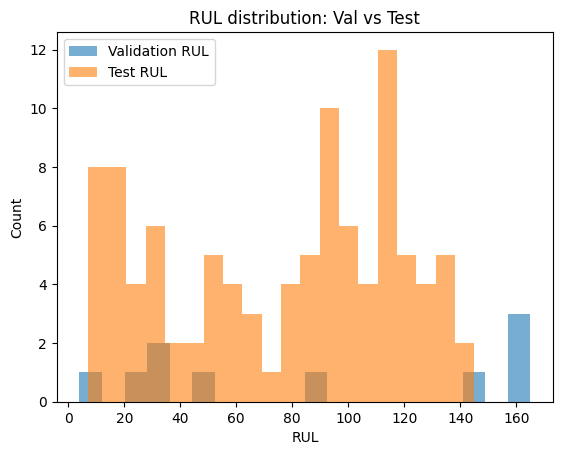

In [ ]:
train_df, test_df, rul_df = load_data(train_path='CMAPSSData/train_FD001.txt',
    test_path='CMAPSSData/test_FD001.txt',
    rul_path='CMAPSSData/RUL_FD001.txt')
train_df, test_rul = compute_rul(train_df, test_df, rul_df)


sensor_cols = [c for c in train_df.columns if 'sensor' in c]
X_train, y_train, X_val, y_val, X_test, y_test, sensor_cols = prepare_datasets(train_df, test_rul, sensor_cols)


# after: X_train, y_train, X_val, y_val, X_test, y_test, sensor_cols = prepare_datasets(…)
import matplotlib.pyplot as plt

# Show summary statistics
print("Validation  RUL summary:")
print(y_val.describe())
print("\nTest  RUL summary:")
print(y_test.describe())

# Overlaid histograms
plt.hist(y_val, bins=20, alpha=0.6, label='Validation RUL')
plt.hist(y_test, bins=20, alpha=0.6, label='Test RUL')
plt.xlabel("RUL"); plt.ylabel("Count")
plt.legend(); plt.title("RUL distribution: Val vs Test")
plt.show()


In [ ]:
# Rank	Model	Reason
# 🥇	SVR (RBF)	Best generalization, lowest test RMSE + MAE, stable performance overall
# 🥈	Random Forest	Strong but mild overfitting; consistent
# 🥉	Linear (Custom/Sklearn)	Basic models, surprisingly good test RMSE due to easy test set
# 🚫	XGBoost	Overfitted; bad test generalization despite good train/val RMSE